In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import einops
from src.layers.flow import get_mask, MaskedLinear

In [ ]:
x = torch.randn(32,10,2)
x_hat = torch.randn(32,10,2)

mse_loss = torch.nn.functional.mse_loss(x_hat, x) * 10 * 2
sum_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='sum') / 32
print(mse_loss)
print(sum_loss)

In [ ]:
x.sum()/32

In [ ]:
x.sum(dim=tuple(range(1, x.ndim))).mean()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
res = np.load('/home/user/data2/ICML_rebuttal/savings/uncond/etth2_24_S/KoVAEorig/cond_None_dtm_True_syn.npy')
# res = np.load('/home/user/data/ICML_rebuttal/savings/uncond/etth2_24_S/KoVAE_orig/cond_None_dtm_True_syn.npy')
start = np.random.randint(0, len(res))
_ = plt.plot(res[start, :, :].squeeze().T)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/home/user/workspaces/THU-timeseries/ETT-small/ETTh2.csv', index_col=0)
# df.values.shape
start = np.random.randint(0, len(df)-24)
_ = plt.plot(df.values[start:start+24, :])

In [ ]:
from abc import ABC, abstractmethod
from typing import List, Optional, Literal
from lightning import LightningModule
import torch
from torch.nn import functional as F

def _condition_shape_check(n_sample, condition, cond_type):
    assert n_sample >=1
    if cond_type is None:
    
        if condition.shape[0] == 1:
            condition = condition.repeat(
                n_sample, *[1 for _ in range(len(condition.shape) - 1)]
            )
        elif condition.shape[0] == n_sample:
            pass
        else:
            raise ValueError(
                "The batch size of the given condition should be the same as n_sample or just 1."
            )
 
    return condition


class BaseModel(ABC, LightningModule):
    """Base class for generative models in PyTorch Lightning"""
    ALLOW_CONDITION = ...
    
    def __init__(self, seq_len, seq_dim, condition, lr, **kwargs):
        super().__init__()
        if condition not in self.ALLOW_CONDITION:
            raise ValueError(f"Condition '{condition}' not allowed. Choose from {self.ALLOW_CONDITION}")
    
    @torch.no_grad()  # wrap with torch.no_grad()
    def sample(self, n_sample: int = 1, condition=None, **kwargs):
        """Generate samples from the generative model"""
        condition = _condition_shape_check(n_sample, condition, self.condition)
        self.eval()
        return self._sample_impl(n_sample, condition, **kwargs)

    @abstractmethod
    def _sample_impl(self, n_sample: int = 1, condition=None, **kwargs) -> torch.Tensor:
        """Actual implementation of the sampling process"""


class MyModel(BaseModel):
    """AAAAAAA

    Args:
        BaseModel (_type_): _description_

    Returns:
        _type_: _description_
    """
    ALLOW_CONDITION = [None, 'predict']
    def __init__(self, seq_len, seq_dim, condition, lr, **kwargs):
        """aaaaaaa

        Args:
            seq_len (_type_): _description_
            seq_dim (_type_): _description_
            condition (_type_): _description_
            lr (_type_): _description_
        """
        super().__init__(seq_len, seq_dim, condition, lr, **kwargs)
    
    def _sample_impl(self, n_sample = 1, condition=None, **kwargs):
        return super()._sample_impl(n_sample, condition, **kwargs)

MyModel
model = MyModel(24, 1, 'impute', 0.001)

In [ ]:
import torch

total_seq_len = 64
num_samples = 200
t = torch.linspace(0, 4 * torch.pi, total_seq_len).float()
curves = []
labels = []
for _ in range(num_samples):
    a = torch.rand(1).item() * 0.5  # Initial radius
    b = torch.rand(1).item() * 0.2  # Growth rate

    direction = torch.randint(0, 2, (1,)).item()  # 0=clockwise, 1=ccw

    r = a + b * t
    if direction == 0:
        x = r * torch.cos(t)
        y = r * torch.sin(t)
    else:
        x = -r * torch.cos(t)
        y = r * torch.sin(t)

    x += torch.randn_like(x) * 0.01
    y += torch.randn_like(y) * 0.01

    curve = torch.stack([x, y], dim=1)
    curves.append(curve)
    labels.append(direction)
data, class_cond = torch.stack(curves), torch.tensor(labels).unsqueeze(-1)
print(data.shape, class_cond.shape)

class_cond[1,...,...]

In [ ]:
import torchaudio.transforms as T
import torch

n_fft = 200
hop_length = 10
data = torch.randn(32, 64, 5)
hop_length = 8
print((data.shape[1]) // hop_length + 1)
data = torch.permute(
    data, (0, 2, 1)
)  # we permute to match requirements of torchaudio.transforms.Spectrogram
spec = T.Spectrogram(n_fft=15, hop_length=hop_length, center=True, power=None).to(data.device)
transformed_data = spec(data)
transformed_data.shape

In [ ]:
import numpy as np

def sine_data_generation(no, seq_len, dim, freq_scale=1):

    """Sine data generation.
  
    Args:
    
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
    Returns:
    - data: generated data
    
    """
    # Initialize the output
    data = list()

    # Generate sine data
    for i in range(no):      
        # Initialize each time-series
        temp = list()
        # For each feature
        for k in range(dim):
            # Randomly drawn frequency and phase
            freq = np.random.uniform(0.05, 0.4)            
            phase = np.random.uniform(0, 1.5)
                
            # Generate sine signal based on the drawn frequency and phase
            temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
            temp.append(temp_data)
            
        # Align row/column
        temp = np.transpose(np.asarray(temp))        
        # Normalize to [0,1]
        temp = (temp + 1)*0.5
        # Stack the generated data
        data.append(temp)
                    
    return data

In [ ]:
from src.model.flow.fourierflow._fourier import DFT, reconstruct_DFT
import numpy as np
import torch

t = np.linspace(0, 6, 65)
k = int(len(t) / 2) + 1

x = np.sin(t) + np.random.randn(*t.shape) * 0.1

x = x.reshape(-1, len(t))
x = torch.from_numpy(x)
m = DFT(x.shape[1])
z, log_pz, log_jacob = m(x)
z = torch.complex(z[:, 0, :], z[:, 1, :])
print("FF implement")
print(z.shape)
print(z)

print("torch.fft.rfft implement")
x_torch_fft = torch.fft.rfft(x) / len(t)
print(x_torch_fft.shape)
x_torch_fft = x_torch_fft.flip(dims=[1]).conj().type_as(z)
print(x_torch_fft.shape)
print(x_torch_fft)
torch.testing.assert_close(x_torch_fft, z)

# x_torch_fft = np.fft.fft(x)
# x_torch_fft = np.fft.fftshift(x_torch_fft)
# print(x_torch_fft.shape)
# print(x_torch_fft)

# x_torch = torch.complex(x_numpy[:,0,:], x_numpy[:,1,:])
# print(x_torch.shape)
# x_irfft = torch.fft.irfft(x_torch, dim=1)
# x_irfft.shape

# x_numpy_r = reconstruct_DFT(x_numpy[0, :, :], component="real").detach().numpy()

# x_numpy_i = reconstruct_DFT(x_numpy[0, :, :], component="imag").detach().numpy()
# print(x_numpy_r.shape)
# print(x_numpy_i.shape)
# np.real(np.fft.ifft(np.fft.ifftshift(x_numpy_r + 1j * x_numpy_i))).shape


In [ ]:
import torch
from src.model.flow.temporalflow._backbones import TempFlowTrainingNetwork

x = torch.randn(1, 7, 3)
obs_x = torch.randn(1, 14, 3)

m = TempFlowTrainingNetwork(
    input_size=x.shape[-1],
    num_layers=1,
    num_cells=3,
    cell_type="GRU",
    context_length=obs_x.shape[1],
    history_length=14,
    prediction_length=x.shape[1],
    dropout_rate=0.1,
    lags_seq=[1],
    target_dim=x.shape[-1],
    conditioning_length=200,
    flow_type='MAF',
    n_blocks=1,
    hidden_size=64,
    n_hidden=64,
    dequantize=False
)

distr_args = m.distr_args(x)
m.flow.log_prob(x, distr_args)

In [12]:
import torch
from torchcde import linear_interpolation_coeffs, natural_cubic_coeffs

x = torch.randn(32, 10, 2)
x[11,3,0] = float('nan')
x[1,6,1] = float('nan')
x[3,1,0] = float('nan')

print(x.shape)
print(linear_interpolation_coeffs(x).shape)
print(natural_cubic_coeffs(x).shape)


torch.Size([32, 10, 2])
torch.Size([32, 10, 2])
torch.Size([32, 9, 8])


In [2]:
import numpy as np

data = np.random.randn(100, 24, 7)
X = [np.hstack((0, data[k][:, 0])) for k in range(len(data))]
X = np.array(X)
X.shape


(100, 25)

In [6]:
from io import StringIO
import pandas as pd
import requests

# url = 'https://raw.githubusercontent.com/jsyoon0823/TimeGAN/refs/heads/master/data/stock_data.csv'
url = 'https://raw.githubusercontent.com/jsyoon0823/TimeGAN/refs/heads/master/data/energy_data.csv'
headers = {"Authorization": "Test"}
response = requests.get(url, headers=headers)
df = pd.read_csv(StringIO(response.text))
df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [23]:
import os
import numpy as np
import torch
from torchvision.datasets.utils import download_url


try:
    from dm_control import suite  # noqa: F401
except ImportError as e:
    raise Exception(
        "Deepmind Control Suite is required to generate the dataset."
    ) from e

env = suite.load("hopper", "stand")
physics = env.physics

# Store the state of the RNG to restore later.
st0 = np.random.get_state()
np.random.seed(123)

num_samples = 10
total_seq_len = 1000
seq_dim = 14

data = np.zeros((num_samples, total_seq_len, seq_dim))
for i in range(num_samples):
    with physics.reset_context():
        # x and z positions of the hopper. We want z > 0 for the hopper to stay above ground.
        physics.data.qpos[:2] = np.random.uniform(0, 0.5, size=2)
        physics.data.qpos[2:] = np.random.uniform(
            -2, 2, size=physics.data.qpos[2:].shape
        )
        physics.data.qvel[:] = np.random.uniform(
            -5, 5, size=physics.data.qvel.shape
        )
    for t in range(total_seq_len):
        data[i, t, : seq_dim // 2] = physics.data.qpos
        data[i, t, seq_dim // 2 :] = physics.data.qvel
        physics.step()

# Restore RNG.
np.random.set_state(st0)

print(data)

[[[ 3.48234593e-01  1.43069667e-01 -1.09259419e+00 ...  2.29049707e+00
   -6.14277553e-01 -4.40322103e+00]
  [ 3.57006666e-01  1.43914669e-01 -1.08272830e+00 ... -7.58552159e+00
    4.75833684e+00 -1.64049076e+01]
  [ 3.65610110e-01  1.45319038e-01 -1.06557560e+00 ... -1.20864340e+01
    7.07552340e+00 -2.13897833e+01]
  ...
  [ 1.31430686e+00 -7.42907583e-01  2.97253634e-01 ...  1.73093778e-04
   -6.23634826e-02  2.57127403e-05]
  [ 1.31435765e+00 -7.42934719e-01  2.98132812e-01 ...  1.76209550e-04
   -6.24781866e-02  2.56903429e-05]
  [ 1.31440864e+00 -7.42961973e-01  2.99015737e-01 ...  1.78969543e-04
   -6.25960378e-02  2.57598774e-05]]

 [[ 1.99022128e-01  3.68997703e-01 -1.27003308e+00 ... -1.77041086e+00
   -1.38211344e+00 -2.71736769e+00]
  [ 2.15597170e-01  3.80644784e-01 -1.29553138e+00 ... -3.64098751e+00
   -2.01197665e+00 -2.82185175e+00]
  [ 2.31829208e-01  3.92409770e-01 -1.33418377e+00 ... -4.42428918e+00
   -2.28481769e+00 -2.85854334e+00]
  ...
  [ 3.04384434e+00 -9.3

/tmp/ipykernel_227161/3931829108.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()


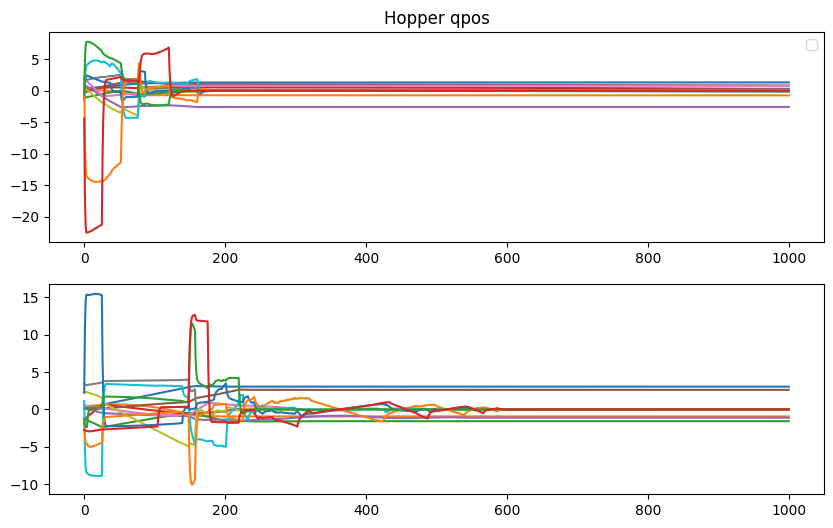

In [24]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs = axs.flatten()
axs[0].plot(data[0, :, :14])
axs[1].plot(data[1, :, :14])
axs[0].set_title('Hopper qpos')
axs[0].legend() 